# PyPSA - Python for Power System Analysis
Es una librería de Python que permite el modelado de redes eléctricas y su posterior optimización.

La documentación del proyecto Pypsa se puede consultar en https://pypsa.readthedocs.io/en/latest/

Repositorio: https://github.com/PyPSA/PyPSA

Tutorial en https://fneum.github.io/data-science-for-esm/09-workshop-pypsa.html

Documentación de los componentes: https://pypsa.readthedocs.io/en/latest/user-guide/components.html

Datos para simulación: https://www.renewables.ninja/

Proyecto para estudio: https://pypsa.readthedocs.io/en/latest/examples/stochastic-problem.html


# Objetivo: resolución de flujo de carga con PyPSA

Definir en PyPSA una instalación con las siguientes características:
Instalación domestica de autoconsumo monofásica con paneles solares y batería
La instalación dispone de 
- Una conexión a la red eléctrica ac monofásica a 230V 50Hz
- Consumidores de la vivienda: ac monofásicos a 230V 50Hz 
- Una batería de 25.6V conectada al bus bat_dc_bus
- Un inversor DC-AC que genera corriente ac monofásica 230V 50Hz para inyectarla a la red o alimentar los consumidores obteniendo energía del bat_dc_bus 
- Un cargador AC-DC que toma energía de la red eléctrica ac monofásica y la deposita en el bat_dc_bus para cargar la batería
- Un cargador solar DC-DC que toma energía de los paneles solares a un nivel de tensión de 150V e DC y la inyecta en el bat_dc_bus para permitir la carga de la batería o alimentar el inversor DC-AC

# Información general
Obtenida de https://pypsa.readthedocs.io/en/latest/user-guide/optimal-power-flow.html
n=0,1,2,3 numera los buses
t=0,1,2,... etiqueta las snapshots (simulaciones de distintos escenarios)
l=0, etiqueta las ramas (lineas que unen diferentes conjuntos de buses)
s= numera los distintos generadores de cada bus

n=0, grid_ac_bus -->s=0, generator= grid_generator
n=1, house_ac_bus --> s=none (no tiene generadores)
n=2, bat_dc_bus --> s=0, storage = battery
n=3, solar_dc_bus --> s=0, generator= solar_panels

w_t, peso que tendrá la snapshot en la función objetivo
g_n_s_t, envío que tendrá el generador s del bus n en el momento t

_g_n_s, potencia nominal del generador s del bus n (n.generators.p_nom)
_g_n_s_t, disponibilidad de la potencia nominal del generador s del bus n en el momento t

_h_n_s, potencia nominal de la batería s del bus n (n.storage_units.p_nom)
h_n_s_t, descarga que tiene la batería (storage unit) s del bus n en el momento t
f_n_s_t, carga que tiene la batería (storage unit) s del bus n en el momento t
soc_n_s_t, estado de carga de la batería (storage unit) s del bus n en el momento t
r_n_s, número de horas a potencia nominal que se necesitan para rellenar la batería (storage unit) s del bus n

c_n_s, coste de instalar (o incrementar) 1MW de potencia el generador s del bus n (precio kW ??)
o_n_s, coste marginal del generador s del bus n (MW) (precio kWh)

f_l_t, flujo de potencia de la rama l en el instante t

Fl, capacidad de la rama l

eta_n_s, eficiencia del generador s del bus n
eta_store_n_s, eficiencia de carga de la batería s del bus n
eta_dispatch_n_s, eficiencia de descarga de la batería s del bus n

eta_l, eficiencia del link l --> ¿link y branches son lo mismo en cuanto al subíndice l?

Función objetivo, que se define en términos económicos aproximadamente como:
F= (costes de instalación) + w_t * (costes de operación del escenario t)
No queda claro si en esta función o como otra función objetivo se incluirá el desgaste de 
las baterías (coste de producir ciclos en ellas) y estado de carga de las mismas.
Parece que en F también se tiene en cuenta el valor h que puede representar la amortización de la inversión.

Nota: en la librería se hace uso de magnitudes per unit, que representan un factor que multiplicado por la potencia nominal
de un generador o la capacidad de una rama, nos da la potencia o capacidad real.
Es decir p_nom=100 y p_max_pu=0.5, p_max=50

Restricciones para los generadores:
-Potencia nominal n.generators.p_nom
-Potencia limite que en un momento dado puede llegar a suministrar _g_n_s_t (baja producción solar inferior a la nominal)
-Potencia instantánea que realmente está suministrando g_n_s_t y que puede ser optimizada 
    (solo se le requiere esta parte por cuestiones operativas o económicas)
- Siempre se cumple que  g_n_s_t * p_nom <= _g_n_s_t * p_nom

Cuando no se necesita optimizar la capacidad de un generador, es decir no se va ampliar la instalación, usaremos
n.generators.p_nom_extendable=False y no es necesario especificar n.generators.p_nom_min ni n.generators.p_nom_max

Restricciones de las baterías (storage units):
Es posible realizar cálculos para optimizar la potencia de carga y descarga de las baterías.
Si se necesita optimizar la capacidad de una batería, se debe usar el componente store y no storage_unit.
soc_n_s_t = eta_stand_n_s*soc_n_s_t-1 + eta_charge_n_s*f_n_s_t - eta_discharge_n_s*h_n_s_t +
Para especificar el soc inicial hay que hacer:
n.storage_units.cyclic_state_of_charge = False y también n.storage_units.state_of_charge_initial={valor} que corresponde a t-1
Por defecto el timeseries n.storage_units_t.state_of_charge_set tiene todo valores NaN. Sin embargo podemos especificar
valores para cada t que obligarán a la batería a tener un estado de carga concreto en ese momento y que generarán restricciones.

Restricciones de los links (conversores de energía entre buses):
Los links suelen tener un flujo controlable.
Si el f_l_t>0 va del bus0 al bus1 aportando solo la fracción f_l_t*eta_l de la potencia que entra en el bus0

Restricciones de activación y desactivación de generadores y links:
n.generators.committable=True permite activar y desactivar generadores y links
En este caso tiene sentido el uso de u_n_s_t que es una variable binaria que indica si el generador s del bus n 
está activo en el momento t. Esto se almacena en n.generators_t.status
Este ajuste necesariamente implica que n.generators.p_nom_extendable=false
Se pueden especificar tiempos mínimos de uso con n.generators.min_up_time y n.generators.min_down_time

Restricciones de flujo de potencia:
Siempre existe una restricción global que hace que
g_n_s_t + h_n_s_t - f_n_s_t = d_n_s_t siendo d_n_s_t la demanda del bus n en el momento t (n.loads_t.p_set)

Diferentes enfoques de optimización de la inversión en función de los periodos a considerar:
Tipo I: Se aplican los costes de inversión a un día completo
Tipo II: Se aplican los costes de inversión a un periodo de tiempo más largo (semanas, meses, años) 
Tipo II necesita n.optimize(multi_investment_periods=True) e indicar los periodos de inversión en n.investment_periods=[2020,2030,2040]

Restricciones globales (aplican a varios componentes):
Ejemplo restricciones de emisiones máximas de CO2
n.add("GlobalConstraint", "co2_limit", carrier_attribute="co2_emissions", sense="<=", constant=1000)

Investigar el uso de pypsa.optimization.abstract para ver como definir las reglas de un ESS (Energy Storage System)
https://pypsa.readthedocs.io/en/latest/examples/optimization-with-abstract.html

Posibilidad de definir restricciones personalizadas con n.add("Constraint", "my_constraint", rule=my_rule)
Diferenciar entre modelo m y network n m=n.optimize.create_model()
m.add_constraints(constraint_expression, name="Bus-minimum_generation_share")
n.optimize.solve_model(m)

Fijar variables
Es posible establecer las variables a estados o valores concretos mediante pandas.dataframe que tengan una columna con el
mismo nombre que la variable y el sufijo _set. Por ejemplo n.generators_t.status_set
Ejemplo fijar la salida de un generador 'gas1' para todos los snapshots
n.generators_t['p_set'] = pd.DataFrame(200, index=n.snapshots, columns=['gas1'])

lopf se refiere a Linear Optimal Power Flow

Siempre se deben especificar al menos los siguientes valores para poder lanzar la optimización lopf:
n.snapshots, n.snapshots_weight, n.buses_t.p_set, n.lines.s_nom
Ver inputs en https://pypsa.readthedocs.io/en/latest/user-guide/optimal-power-flow.html
"""

## Configuración del entorno básico en VSCode para Windows
Para los ejemplos se usará Python 3.12, no obstante pueden ser válidas otras versiones.

Elegir una carpeta donde se ubicará el entorno virtual. Puede ser la carpeta del workspace de VSC o otra fuera de él.
En mi caso voy a crear el entorno virtual en SSD externo en la ruta `E:\python_envs\pypsa_env`
Nos situamos en `E:\python_envs`, y para crear un entorno virtual en Python 3.12 en la carpeta `pypsa_env`
```bash
python3.12 -m venv pypsa_env
```
Para activar el entorno virtual debemos estar en la carpeta `E:\python_envs` donde escribimos
```bash
pypsa_env\Scripts\activate
```
- Instalar PyPSA
```bash
pip install pypsa
```
La librería pypsa tiene muchas dependencias que se instalarán por completo. La instalación ocupara aproximadamente 600MB
- Si queremos fijar requerimientos en un archivo requirements.txt para posteriormente migrar el entorno a otra plataforma
```bash
pip freeze > requirements.txt
```

Si posteriormente se quiere reproducir el entorno en otro equipo
```bash
pip install -r requirements.txt
```

## Primeros pasos con el código Python
Es importante tener claro donde queremos que se busquen y guarden los archivos de nuestro notebook
Para ello lo primero que haremos ser especificar el Current Working Dir para que apunte a una determinada carpeta.
Ojo con las dobles barras invertidas en Windows para la ruta. (se pueden también cambiar por / al estilo Linux)

In [1]:
import os
os.chdir('H:\\python_envs\\jupyter_files')

In [2]:
# Importar librerías que serán necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
# Importar la librería Pypsa y crear una instancia de la red
import pypsa
n=pypsa.Network()

Vamos a crear una instalación de ejemplo para nuestro ESS que intentaremos encajar en el siguientes esquema

<img src="..\victron_ess_schema.png" alt="Instalación" width="400"/>


Pypsa define la red utilizando unos cuantos elementos básicos. Para nuestro propósito bastará con los siguientes
- buses: que representan nodos de la red que trabajan a una determinada tensión
- generators: son generadores de energía de cualquier tipo
- loads: consumidores
- links: convertidores de energía que comunican buses
- storage_units: para el almacenamiento

Un elemento fundamental en Pypsa son las líneas `lines`, pero en principio no las usaremos ya que la escala de nuestra instalación no requiere representar las conexiones como líneas de trasmisión, y haremos los enlaces mediante links.

Cada uno de estos elementos tiene muchas propiedades que es posible especificar, no obstante nos limitaremos a indicar las estrictamente necesarias para nuestro propósito por lo que las no indicadas quedarán con valores por defecto.

Pypsa no define explícitamente las unidades de las magnitudes con las que trabaja pero sí que es necesario entender cuales son sus criterios para poder llevarlos a otra escala que mantenga las mismas proporciones previstas en Pypsa.
Vamos a partir de la siguiente información:
| Magnitud        | Abreviaturas Pypsa          | Unidades Pypsa | Unidades TFG |
|-----------------|-----------------------------|----------------|--------------|
| Voltage         | v, v_nom                    | kV             | V            |
| Potencia        | p, p_nom                    | MW             | kW           |
| Energia         | e                           | MWh            | kWh          |
| Energia batería | p_non*max_hours             | MWh            | kWh          |
| Precios         | marginal_cost, capital_cost | €/MWh          | €/kWh        |
| Vida útil       | lifetime                    | Años           | Años         |
| SoC             | state_of_charge_initial     | MWh            | kWh          |

Pypsa es una herramienta pensada para modelar la red energética mundial  por lo que ofrece herramientas orientadas a la representación geográfica sobre mapas. Cuando se definen los buses se pueden especificar las coordenadas x, y donde se ubicarán. En nuestro caso vamos a emplear esta característica para que los buses queden reflejados en la escala de nuestra imagen de la instalación.
Vamos a determinar las coordenadas de los puntos de la imagen donde queremos ubicar los buses.
Colocamos la imagen en nuestro cwd en `E:\python_envs\jupyter_files\victron_ess_schema.png`
Y cargamos la imagen usando matplotlib. 
Con la instrucción `ax.imshow(img, extent=[x_min, x_max, y_min, y_max])` definiremos un rango para el sistema de coordenadas que vamos a hacer coincidir con las dimensiones en pixels de la imagen.
Este proceso se hace mejor fuera de jupyter, ya que en las ventanas emergentes de Matplotlib, es posible ver las coordenadas en tiempo real.
Como ayuda se puede usar el script `get_image_points.py`.

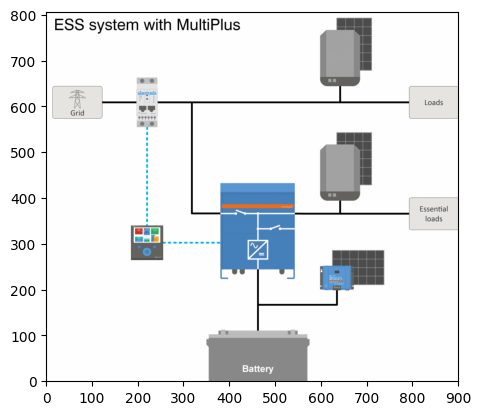

In [4]:
img = mpimg.imread('victron_ess_schema.png')
height, width, _ = img.shape # 'shape' devuelve (alto, ancho, canales de color)
extent = [0, width, 0, height] # [xmin, xmax, ymin, ymax]
# Mostrar la imagen de fondo
fig, ax = plt.subplots()
ax.imshow(img, extent=extent)  # Ajustar el gráfico a las dimensiones de la imagen
plt.show() # Mostrar el gráfico

Has hecho clic en: x=317, y=607

Has hecho clic en: x=460, y=168

Has hecho clic en: x=658, y=299

Has hecho clic en: x=732, y=367

Una vez obtenidas las coordenadas, las introduciremos como parámetros `x` e `y` al crear los buses.

## Definición de componentes de la instalación mediante código Python

In [5]:
# Añadir buses
# Las tensiones en Pypsa se introducen en kV pero usamos V para luego escribir potencias en kW
# Las potencias en Pypsa se introducen en MW pero usamos kW por conveniencia.

n.add("Bus", "grid_ac_bus", v_nom=230, carrier="AC", x=317, y=607)  # Red AC monofásica 230V 
n.add("Bus", "house_ac_bus", v_nom=230, carrier="AC", x=730, y=367)  # Consumidores AC de la vivienda
n.add("Bus", "bat_dc_bus", v_nom=25.6, carrier="DC", x= 460, y=168)  # Bus DC de la batería de 25.6V nominales
n.add("Bus", "solar_dc_bus", v_nom=150, carrier="DC", x=658, y= 299)  # Bus DC de los paneles solares, 150V aproximadamente

Index(['solar_dc_bus'], dtype='object')

A pesar de que podríamos usar un único bus para la AC, se han diferenciado el bus de la red `grid_ac_bus` del bus de los consumidores `house_ac_bus` con el objetivo de poder manejar en el futuro la situación del corte de la red mediante el contactor dentro del Multiplus II y trabajar en modo aislado en determinados momentos. Este contactor quedará representado por un link sin perdidas de energía.

Al ser una red eléctrica pequeña no es necesario definir las líneas de transmisión y se consideran todo buses conectados directamente
Si fueran necesarias usaríamos la siguiente línea de código:
```python
n.add("Line", "grid_connection_line", bus0="grid_ac_bus", bus1="house_ac_bus", x=0.1, r=0.01, s_nom=10) # Unir la red con los consumidores
```
Donde `x` representa la reactancia y `r` la resistencia de toda la longitud de la línea.

En un sistema de corriente alterna (AC), el flujo de potencia depende de las diferencias de ángulo de fase entre diferentes buses. 
El bus slack se usa para definir el ángulo de referencia, que se suele establecer en 0º para facilitar los cálculos.
El hecho de ser Slack implica que la red se comporta como si fuera una red infinita. Cualquier diferencia entre la demanda total de la red (consumo de los consumidores) y la producción total de energía de los generadores programados (exceptuando el slack) será absorbida o suministrada por el generador slack.

En Pypsa es muy habitual el uso de magnitudes per unit. En estos casos se refiere a multiplicadores que se aplican al valor nominal.
Por ejemplo para la potencia nominal de un generador tenemos: p_nom=100 y p_max_pu=0.5, p_max=50
Para la definición del contactor tendremos en cuenta la siguiente explicación obtenida de la documentación de Pypsa:
NB: for a lossless bi-directional HVDC or transport link, set p_min_pu = -1 and efficiency = 1.

In [6]:

# Consumo de la vivienda
n.add("Load", "house_load", bus="house_ac_bus")  

# Red eléctrica representada por un generador de 10 kW
n.add("Generator", "grid_generator", bus="grid_ac_bus", p_nom=10, control="Slack", slack=True)  # Generador Slack (referencia del sistema)

# Contactor que conecta la red con la vivienda
n.add("Link", "contactor", bus0="grid_ac_bus", bus1="house_ac_bus", p_nom=10, efficiency=1, p_min_pu = -1) # -1 para que sea bidireccional


Index(['contactor'], dtype='object')

En Pypsa las unidades de almacenamiento se pueden representar con dos componentes diferentes:
- `Store`: Almacenamiento genérico que ofrece posibilidad de optimizar su capacidad.
- `StorageUnit`: Unidad de almacenamiento con capacidad fija. (ratio fijo max_hours = e_non / p_non)

Ambos componentes tienen enfoques diferentes en cuanto a la valoración del coste marginal `marginal_cost`:
- `Store`: El coste aplica tanto a la carga como a la descarga con distinto signo. Si eficiencia es 1 coste neto = 0
- `StorageUnit`: El coste solo se imputa en las descargas.

La utilización de un Store puede tener sentido para representar una venta de energía fuera de la instalación. Explorar su uso para la devolución de energía a la red.

La definición mínima de una batería implica informar de las eficiencias de carga `efficiency_store` y descarga `efficiency_dispatch` y de la cantidad de energía que es capaz de almacenar `e_nom`, bien sea mediante la potencia nominal y las horas que se requieren a esa potencia para alcanzar la energía nominal `max_hours` o directamente como energía nominal.
Al hablar de potencias hay que diferenciar dos conceptos:
- `p_nom`: input que representa la potencia nominal limite utilizada para la optimización del flujo de potencia (OPF) en kW. Se debería cumplir que e_nom=max_hours*p_nom, pero se pueden fijar todos independientemente para no trabajar al máximo de potencia posible.
- `p_nom_mod`: la unidad de almacenamiento puede estar compuesta por varios módulos que en suma darán `p_nom` y está unidad minima será la base para calcular variaciones. generalmente si hay n módulos p_nom=n * p_nom_mod.

Los estados de carga no se dan en % sino que se dan en unidades de energía, así para indicar el estado inicial justo al comienzo de una optimización usaremos `state_of_charge_initial` dando su valor en kWh (realmente para Pypsa con MWh). Para consultar el estado de carga en cualquier momento de usará `state_of_charge` en kWh.
Para las optimizaciones, se podrá informar del estado de carga deseado en un momento dado mediante `state_of_charge_set` o bien indicar 

Para el calculo del coste marginal usaremos:
BATTERY_PURCHASE_PRICE = 2000 Precio de compra de la batería
BATTERY_CHARGING_CYCLES = 5000 Vida útil de la batería. Cada ciclo representa una carga y una descarga completa
BATTERY_ENERGY_PRICE = BATTERY_PURCHASE_PRICE / (BATTERY_CHARGING_CYCLES * BATTERY_CAPACITY_WH) = 0.156 €/kWh

In [7]:
# Batería Victron LFP- Smart 25,6/100, de 25,6 voltios y 100 Ah (e_nom=2,56 kWh) con una corriente de carga máxima de 50 A 
# y una corriente de descarga máxima de 100 A, asumiendo 50 A para ambos casos -> p_nom = 25.6 *50/1000 = 1.28 kW 
# # max_hours = e_non / p_non = 2.56/1.28 = 2 horas

n.add("StorageUnit", "battery", bus="bat_dc_bus", e_nom=2.56, p_nom=1.28, marginal_cost=0.156, 
      efficiency_store=0.92, efficiency_dispatch=0.92, e_initial=1.28, cyclic_state_of_charge=True)

Index(['battery'], dtype='object')

EasySolar-II 24/3000/70-32 
Inersor: Multiplus II 24/3000/70-32 

MPPT 250/70 GX : Corriente de carga nominal 70A P=2000W si batería de 24

In [8]:
# Inversor DC-AC para alimentar consumidores o inyectar a la red
n.add("Link", "inverter_to_consumers", bus0="bat_dc_bus", bus1="house_ac_bus", 
            p_nom=3, efficiency=0.94)
n.add("Link", "inverter_to_grid", bus0="bat_dc_bus", bus1="grid_ac_bus", 
            p_nom=3, efficiency=0.94)

# Cargador AC-DC para cargar la batería desde la red
n.add("Link", "ac_dc_charger", bus0="grid_ac_bus", bus1="bat_dc_bus", 
            p_nom=1.9, efficiency=0.9)

# Generación mediante paneles solares, eficiencia 1 ya que los datos de Forecast.Solar ya vienen corregidos 
n.add("Generator", "solar_panels", bus="solar_dc_bus", p_nom=1.65, 
            marginal_cost=0, efficiency=1) # Suponemos que la potencia nominal es 1.65 kW

# Cargador solar DC-DC para inyectar energía en el bus de la batería desde los paneles solares
n.add("Link", "solar_dc_dc_charger", bus0="solar_dc_bus", bus1="bat_dc_bus", 
            p_nom=2, efficiency=0.99)

Index(['solar_dc_dc_charger'], dtype='object')

## Inspeccionar datos de la instalación
Ahora que ya tenemos componentes creados podemos inspeccionar su contenido:

In [9]:
# Mostrar los generadores
n.generators


,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt,slack
Generator,,,,,,,,,,,,,,,,,,,,,
grid_generator,grid_ac_bus,Slack,,10.00,0.0,False,0.0,inf,0.0,1.0,...,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0,True
solar_panels,solar_dc_bus,PQ,,1.65,0.0,False,0.0,inf,0.0,1.0,...,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0,NaN


In [10]:
# Para hacer referencia a una propiedad concreta del generador `grid_generator` se puede hacer de la siguiente forma:
n.generators.p_nom["grid_generator"]

10.0

In [11]:
# Tambien es posible hacer referencia a una propiedad concreta del generador `grid_generator` de la siguiente forma:
n.generators.loc["grid_generator", "p_nom"]

10.0

Todavía no hemos definido el horizonte temporal por lo que por el momento solo existe una snapshot que representa el instante now

In [12]:
n.snapshots

Index(['now'], dtype='object', name='snapshot')

Podemos definir una serie de momentos temporales rellenando datos en el componente snapshots

In [13]:
# Añadir un snapshot para cada hora del día
n.set_snapshots(range(24))
n.snapshots

RangeIndex(start=0, stop=24, step=1, name='snapshot')

Las magnitudes que evolucionan temporalmente están representada mediante variables con el sufijo `_t`
Por el momento la mayor parte de los elementos temporales no contienen datos. Cuando realicemos la optimización se irán rellenando.
Sin embargo, para las variables que queramos que sean entradas sí podemos ir especificando sus valores.
Por ejemplo, podemos definir como queremos que evolucionen temporalmente las cargas.
Dentro de cada componente, tendremos `componente_t` por ejemplo `loads_t`, y cada uno de estos registros temporales del componente tienen sus propios campos como por ejemplo `p_set`. Dado que en el componente `loads` hemos podido definir distintas cargas, para hacer referencia a una concreta usaremos `.loc` y a continuación formato matricial.
En las tablas temporales, el primer indice hace referencia al tiempo.

In [14]:
# Añadir datos del consumo previsto de la vivienda
n.loads_t.p_set.loc[:,"house_load"] = [i%6 for i in range(24)]  # Consumo hipotético de la vivienda en kW
n.loads_t.p_set

Load,house_load
snapshot,
0,0
1,1
2,2
3,3
4,4
5,5
6,0
7,1
8,2


Los datos se pueden representar fácilmente haciendo uso de las funciones plot integradas en Pypsa

<Axes: title={'center': 'Consumo de la vivienda'}, xlabel='Hora', ylabel='kW'>

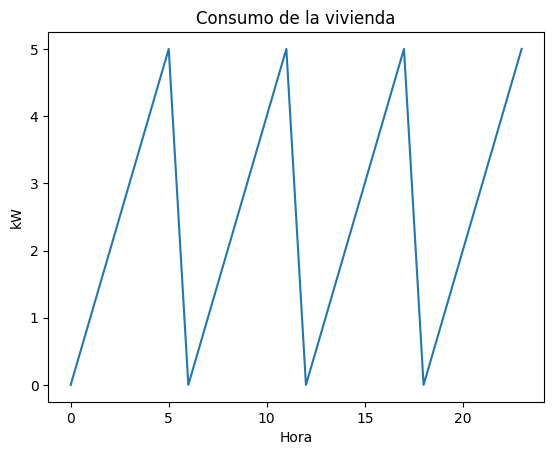

In [15]:
# Representar gráficamente el consumo de la vivienda
n.loads_t.p_set.loc[:,"house_load"].plot(kind='line', title='Consumo de la vivienda', xlabel='Hora', ylabel='kW')

## Representación gráfica de la instalación con buses y links
Vamos a representar gráficamente nuestra red sobre la imagen mediante la instrucción `n.plot`.
Está instrucción está orientada a representar con círculos los `buses`, y con lineas tanto `links` como `lines`.
La función `n.plot` en si misma no permite el etiquetado de los buses, pero nada impide que lo hagamos directamente utilizando herramientas estándar de Matplotlib.
Se debe tener en cuenta que `n.plot` está pensada para representar sobre mapas geográficos las topologías de redes muy extensas, por lo que los tamaños de los círculos y otros elementos se deben ajustar en función de la escala de nuestra instalación. Como no se van a usar datos geográficos establecemos `geomap=False`.
Los valores mostrados para margin y bus_sizes han sido ajustados para conseguir un efecto adecuado al tamaño de la imagen de partida. Margin representa el margen mínimo que se deja desde los buses hasta los bordes de recorte de la imagen.

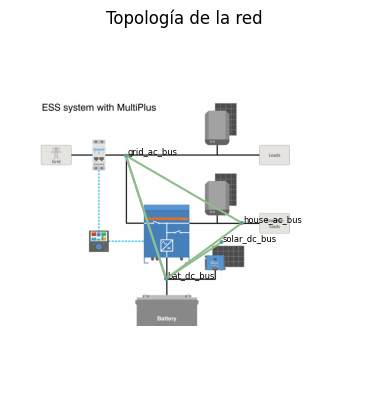

In [16]:
img = mpimg.imread('victron_ess_schema.png')
height, width, _ = img.shape # 'shape' devuelve (alto, ancho, canales de color)
extent = [0, width, 0, height] # [xmin, xmax, ymin, ymax]
# Mostrar la imagen de fondo
fig, ax = plt.subplots()
ax.imshow(img, extent=extent)  # Ajustar el gráfico a las dimensiones de la imagen
for bus in n.buses.index:    
    ax.text(n.buses.loc[bus, 'x'] + 5, n.buses.loc[bus, 'y'] + 5, bus, fontsize=6, color='black')
# Mostrar el mapa de la red eléctrica
n.plot(margin=1, bus_sizes=50, title="Topología de la red", geomap=False, ax=ax)
# Mostrar el gráfico con la imagen de fondo y los buses
plt.show()     

## Exportar instalación a CSV
Vamos a especificar una carpeta dentro del cwd donde crearemos la estructura de nuestra red, carpeta `pypsa_network`
Se crearán archivos CSV que representan los componentes que hemos definido hasta ahora mediante código Python.

In [17]:
# Exportar la estructura a archivos CSV en el directorio "pypsa_network"
n.export_to_csv_folder("pypsa_network")

INFO:pypsa.io:Exported network 'pypsa_network' contains: loads, generators, storage_units, buses, links


Podemos inspeccionar la carpeta y abrir e incluso editar los archivos que se han creado. Los archivos generalmente solo contienen columnas con los parámetros que hemos especificado y no con todos los campos posibles. Lo campos que no indicamos en el código Python, se han creado con valores por defecto y no aparecen en el CSV al usar el comando `n.export_to_csv_folder`. 
Si en algún caso quisiéramos disponer de un CSV con todos los campos posibles, aunque estén vacíos entendiendo que se crearon con valores por defecto, podemos hacer la exportación individual de componentes con instrucciones como las siguientes.
Por el momento parece adecuado tan solo disponer de una lista completa de parámetros solo como referencia. Por tanto lo hacemos en una carpeta diferente de la que contendrá a los ficheros reales con los que trabajaremos.
Para poder abrir y comparar simultáneamente en Excel debemos guardarlos con distinto nombre. Esto puede permitir copiar columnas de un fichero a otro, para añadir parámetros que inicialmente no se habían previsto.

En España tenemos un gran problema de configuración regional para el trabajo con ficheros CSV de otros países. Las diferencias de notación del punto decimal y el separador estándar para ficheros CSV hace que al abrirlos con Excel no sean correctamente interpretados. Mi recomendación es ir a la configuración regional de Windows y establecer el formato regional a Inglés (Estados Unidos). Una vez terminemos las ediciones de los CSV se puede volver a poner en Español (España).

In [18]:
# Crear carpeta en el cwd para exportar los archivos CSV renombrados con el prefijo "full_options" 
os.makedirs("pypsa_network_full_options", exist_ok=True)
n.buses.to_csv("pypsa_network_full_options/buses_full_options.csv")
n.lines.to_csv("pypsa_network_full_options/lines_full_options.csv")
n.loads.to_csv("pypsa_network_full_options/loads_full_options.csv")
n.generators.to_csv("pypsa_network_full_options/generators_full_options.csv")
n.storage_units.to_csv("pypsa_network_full_options/storage_units_full_options.csv")
n.links.to_csv("pypsa_network_full_options/links_full_options.csv")

## Entendiendo la nomenclatura de subindices de Pypsa
Información obtenida de https://pypsa.readthedocs.io/en/latest/user-guide/optimal-power-flow.html
n=0,1,2,3 numera los buses
t=0,1,2,... etiqueta las snapshots (suelen representar el tiempo)
l=0, etiqueta las ramas (lineas que unen diferentes conjuntos de buses)
s= numera los distintos generadores de cada bus


## Introducción de entradas temporales desde ficheros
A partir de aquí tenemos que alimentar al sistema con datos de consumo, producción solar y costes de la energía.
También deberemos establecer las condiciones iniciales para la batería.

Pypsa trabaja con el concepto de Snapshots, que representan series temporales donde las entradas y salidas del sistema van evolucionando.

Es interesante colocar todos los archivos que vayan a representar nuestras entradas en la carpeta donde hemos creado la red `pypsa_network`, ya que podemos hacer uso de la instrucción `network = pypsa.Network(import_name='pypsa_network')`
En esta carpeta además de los ficheros que definen los componentes con la topología de la red, podemos crear ficheros CSV que si nombramos de una forma adecuada, se importarán también para rellenar los valores de las entradas.

Por ejemplo en nuestro caso vamos a crear los siguientes ficheros:
| Fichero                    | Nombre Col1 | Ejemplo Col1    | Unid. Col1 | Nombre Col2    | Ejemplo Col2 | Unid. Col2  | Nombre Col3  | Ejemplo Col3 | Unid. Col3  | Nombre Col4 | Ejemplo Col4 | Unid. Col4  |
|----------------------------|-------------|-----------------|------------|----------------|--------------|-------------|--------------|--------------|-------------|-------------|--------------|-------------|
| generators-margin_cost.csv | name        | 10/29/2019 0:00 | no aplica  | grid_generator | 0.15         | €/kWh       | solar_panels | 0            | €/kWh       | battery     | 0.2          | €/kWh       |
| generators-p_max_pu.csv    | name        | 10/29/2019 0:00 | no aplica  | grid_generator | 1            | kWh / kWh_nom | solar_panels | 0.4          | kWh / kWh_nom | battery     | 1            | kWh / kWh_nom |
| loads-p_set.csv            | name        | 10/29/2019 0:00 | no aplica  | house_load     | 0.8          | kW          |              |              |             |             |              |             |
| snapshots.csv              | name        | 10/29/2019 0:00 | no aplica  | weightings     | 11.7742      |

In [19]:
#Cargar de nuevo la red con datos para las entradas definidos en los ficheros CSV
n = pypsa.Network(import_name='pypsa_network')
# Estado de carga inicial de la batería 50%
n.storage_units.at["battery", "state_of_charge_initial"] = 0.5* n.storage_units.at["battery", "e_nom"]  # 50% de la capacidad nominal

h:\vsc_pypsa\.venv\Lib\site-packages\pypsa\io.py:159: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(fn, index_col=0, encoding=self.encoding, parse_dates=True)
h:\vsc_pypsa\.venv\Lib\site-packages\pypsa\io.py:185: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(
INFO:pypsa.io:Imported network pypsa_network has buses, generators, links, loads, storage_units


In [20]:
#Cargar de nuevo la red con datos para las entradas definidos en los ficheros CSV
import pypsa
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
os.chdir('H:\\python_envs\\jupyter_files')
n = pypsa.Network(import_name='data_test_2')


INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network data_test_2 has buses, generators, lines, links, loads, storage_units


In [21]:
n.storage_units.at["battery", "state_of_charge_initial"] = 0.5* n.storage_units.at["battery", "e_nom"]  # 50% de la capacidad nominal
#n.storage_units.at["battery", "state_of_charge_initial"] = 10
# Mostrar el estado de carga inicial de la batería
#n.storage_units.at["battery", "state_of_charge_initial"]

In [22]:
# Añadir una restricción de estado de carga mínima de la batería
n.storage_units.at["battery", "state_of_charge_min"] = 0.2  # 20% de la capacidad

In [23]:
# Mostrar los costes marginales de los generadores. 
# Solo se introduce el PVPC en el generador de la red eléctrica el resto se definieron a 0 en la creación de la red
n.generators_t.margin_cost

Generator,grid_generator,solar_panels,battery
snapshot,,,
2019-10-29 00:00:00,0.000055,0,0.00026
2019-10-29 01:00:00,0.000054,0,0.00026
2019-10-29 02:00:00,0.000051,0,0.00026
2019-10-29 03:00:00,0.000051,0,0.00026
2019-10-29 04:00:00,0.000053,0,0.00026
2019-10-29 05:00:00,0.000068,0,0.00026
2019-10-29 06:00:00,0.000089,0,0.00026
2019-10-29 07:00:00,0.000080,0,0.00026
2019-10-29 08:00:00,0.000121,0,0.00026


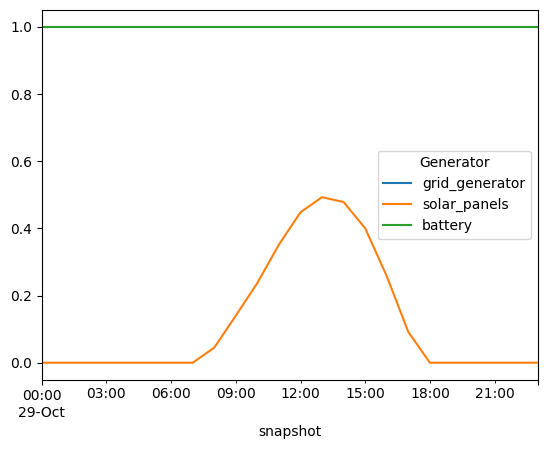

In [24]:
# Mostrar gráficamente las potencias máximas que pueden suministrar los generadores
n.generators_t.p_max_pu.plot()
plt.show()

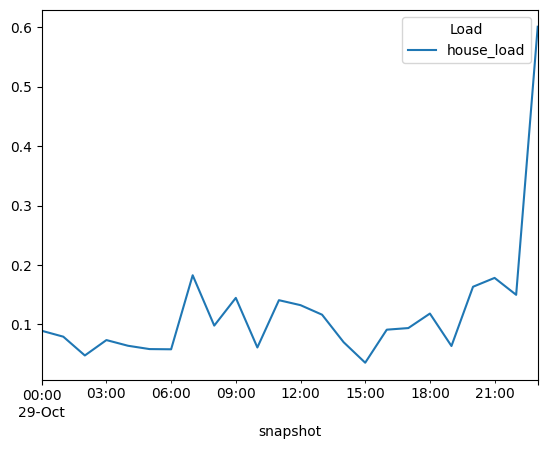

In [25]:
# Mostrar gráficamente las potencias consumidas por las cargas
n.loads_t.p_set.plot()
plt.show()

In [26]:
# Realizar la optimización de la red
n.optimize(solver_name='highs')

Index(['house_load'], dtype='object', name='Load')
Index(['solar_panels'], dtype='object', name='Generator')
Index(['battery'], dtype='object', name='Generator')
Index(['grid_ac_bus', 'house_ac_bus', 'bat_dc_bus', 'solar_dc_bus'], dtype='object', name='Bus')
Index(['contactor', 'inverter_to_consumers', 'inverter_to_grid',
       'ac_dc_charger', 'solar_dc_dc_charger'],
      dtype='object', name='Link')
Index(['house_load'], dtype='object', name='Load')
Index(['solar_panels'], dtype='object', name='Generator')
Index(['battery'], dtype='object', name='Generator')
Index(['grid_ac_bus', 'house_ac_bus', 'bat_dc_bus', 'solar_dc_bus'], dtype='object', name='Bus')
Index(['contactor', 'inverter_to_consumers', 'inverter_to_grid',
       'ac_dc_charger', 'solar_dc_dc_charger'],
      dtype='object', name='Link')
h:\vsc_pypsa\.venv\Lib\site-packages\linopy\common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas

('ok', 'optimal')

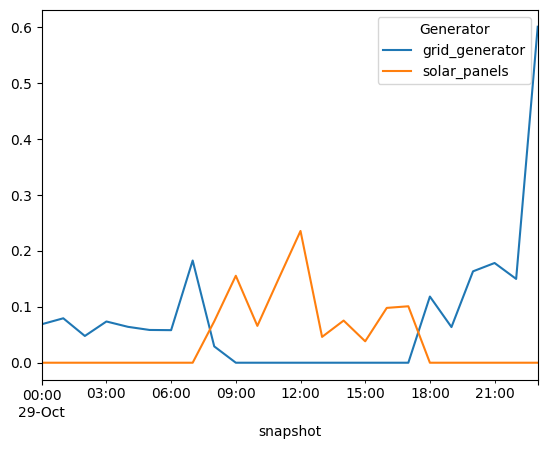

In [27]:
# Mostrar los resultados de la optimización: Generadores
n.generators_t.p.plot()
plt.show()

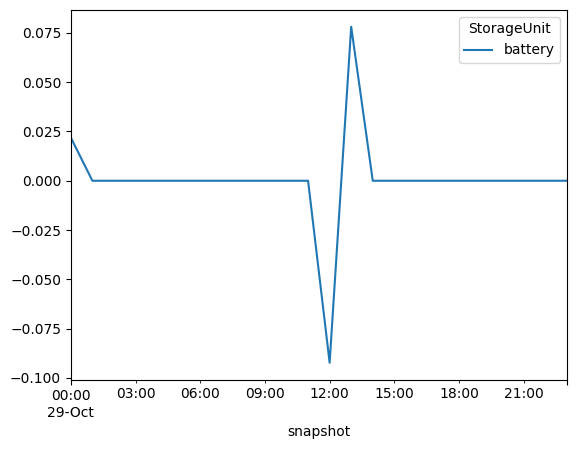

In [28]:
# Mostrar los resultados de la optimización: Potencia Batería
n.storage_units_t.p.plot()
plt.show()

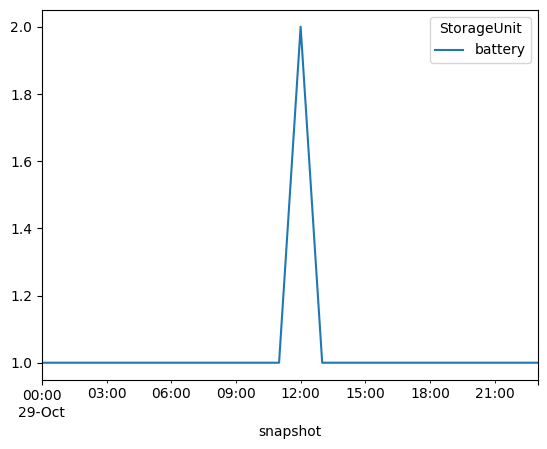

In [29]:
# Mostrar los resultados de la optimización: SoC Batería
n.storage_units_t.state_of_charge.plot()
plt.show()

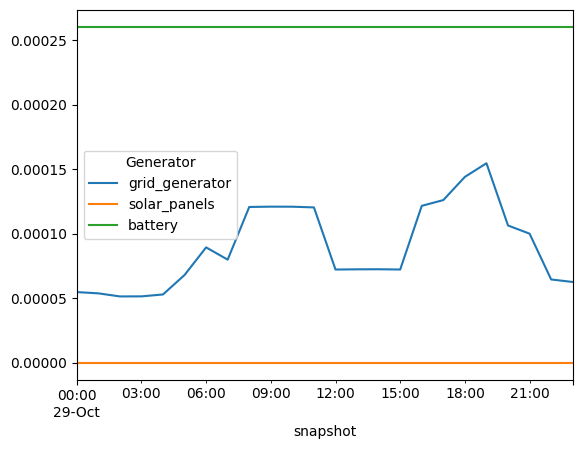

In [30]:
n.generators_t.margin_cost.plot()
plt.show()